In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np

from utils.conn_data import load_pickle
from utils.diagnostics import compute_summary_statistics

plt.style.use('ggplot')

In [2]:
inputs_path = os.path.join(os.getcwd(), "data", "inputs")
outputs_path = os.path.join(os.getcwd(), "data", "outputs")
forecast_input = "wrds_etf_returns"
memory_input = "fredmd_transf"
vol_target = 0.15
portfolio_methods = ["naive",
                     #"weighted-naive",
                     "linear-ridge",
                     ]

In [3]:
# load memory data and preprocess
memory_data = pd.read_csv(os.path.join(inputs_path, f'{memory_input}.csv'))

## fix dates
memory_data["date"] = pd.to_datetime(memory_data["date"])
memory_data = memory_data.set_index("date")
memory_data = memory_data.astype(float)

# fill missing values
memory_data = memory_data.interpolate(method='linear', limit_direction='forward', axis=0)
memory_data = memory_data.ffill()
memory_data = memory_data.bfill()

## compute moving average
memory_data = memory_data.rolling(window=12).mean()

## drop missing values
memory_data = memory_data.dropna()

returns = pd.read_csv(os.path.join(inputs_path, f'{forecast_input}.csv'))
returns = returns[[col for col in returns.columns if "t+1" not in col]]

## fix dates
returns["date"] = pd.to_datetime(returns["date"])
returns["date"] = returns["date"] + pd.DateOffset(months=1)
returns = returns.set_index("date")
memory_data = memory_data.astype(float)

## resample and match memory data dates
returns = returns.resample("MS").last().ffill()
returns = pd.merge(returns, memory_data[[memory_data.columns[0]]], left_index=True, right_index=True).drop(memory_data.columns[0], axis=1)

## drop missing values
returns = returns.dropna()

In [4]:
# get regimes
memory_dir_name = "kmeans_elbow"
memory_results_path = os.path.join("data", "inputs", "memory", memory_dir_name, "results.pkl")
memory_results = pd.read_pickle(memory_results_path)
regimes = memory_results["regimes"]
centroids = memory_results["centroids"]
regimes_probs = memory_results["regimes_probs"]

In [5]:
for x in memory_data.columns:
    print(x)

RPI
W875RX1
DPCERA3M086SBEA
CMRMTSPLx
RETAILx
INDPRO
IPFPNSS
IPFINAL
IPCONGD
IPDCONGD
IPNCONGD
IPBUSEQ
IPMAT
IPDMAT
IPNMAT
IPMANSICS
IPB51222S
IPFUELS
CUMFNS
HWI
HWIURATIO
CLF16OV
CE16OV
UNRATE
UEMPMEAN
UEMPLT5
UEMP5TO14
UEMP15OV
UEMP15T26
UEMP27OV
CLAIMSx
PAYEMS
USGOOD
CES1021000001
USCONS
MANEMP
DMANEMP
NDMANEMP
SRVPRD
USTPU
USWTRADE
USTRADE
USFIRE
USGOVT
CES0600000007
AWOTMAN
AWHMAN
HOUST
HOUSTNE
HOUSTMW
HOUSTS
HOUSTW
PERMIT
PERMITNE
PERMITMW
PERMITS
PERMITW
ACOGNO
AMDMNOx
ANDENOx
AMDMUOx
BUSINVx
ISRATIOx
M1SL
M2SL
M2REAL
BOGMBASE
TOTRESNS
NONBORRES
BUSLOANS
REALLN
NONREVSL
CONSPI
S&P 500
S&P: indust
S&P div yield
S&P PE ratio
FEDFUNDS
CP3Mx
TB3MS
TB6MS
GS1
GS5
GS10
AAA
BAA
COMPAPFFx
TB3SMFFM
TB6SMFFM
T1YFFM
T5YFFM
T10YFFM
AAAFFM
BAAFFM
TWEXAFEGSMTHx
EXSZUSx
EXJPUSx
EXUSUKx
EXCAUSx
CES0600000008
CES2000000008
CES3000000008
UMCSENTx
DTCOLNVHFNM
DTCTHFNM
INVEST
VIXCLSx
WPSFD49207
WPSFD49502
WPSID61
WPSID62
OILPRICEx
PPICMM
CPIAUCSL
CPIAPPSL
CPITRNSL
CPIMEDSL
CUSR0000SAC
CUSR0000SAD
CU

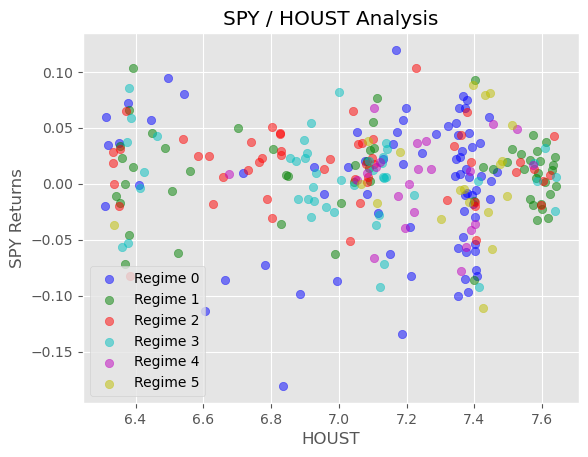

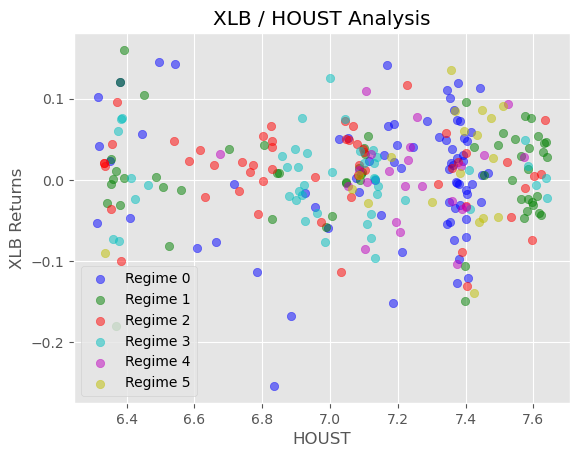

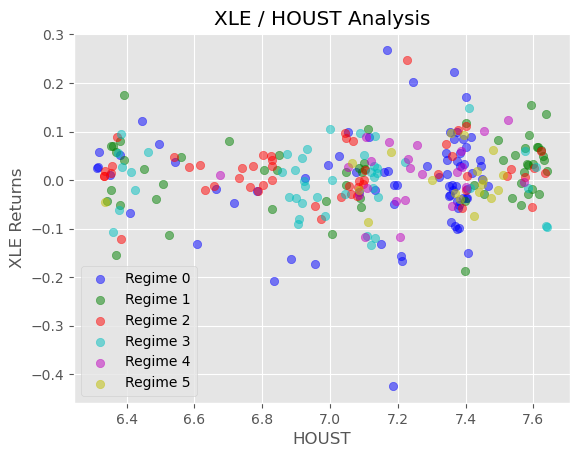

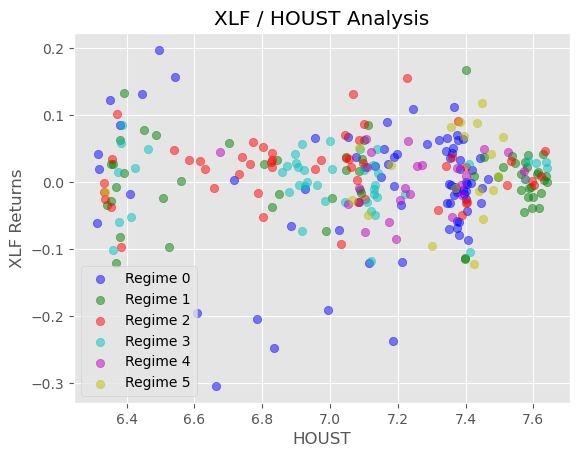

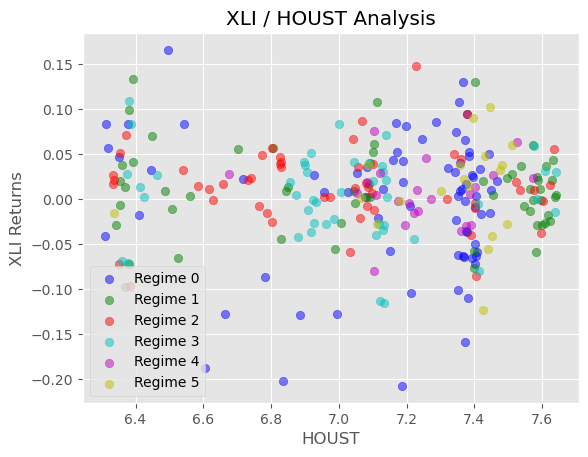

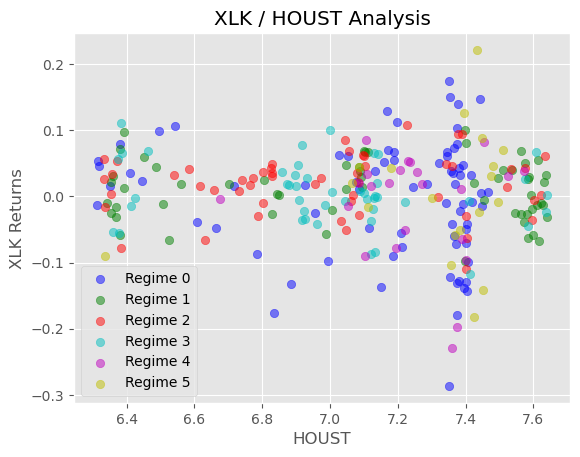

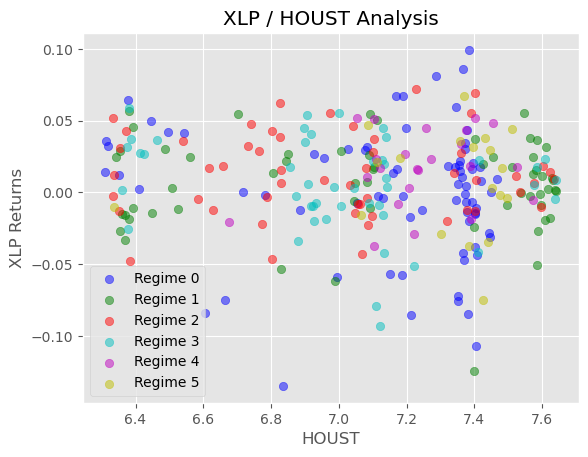

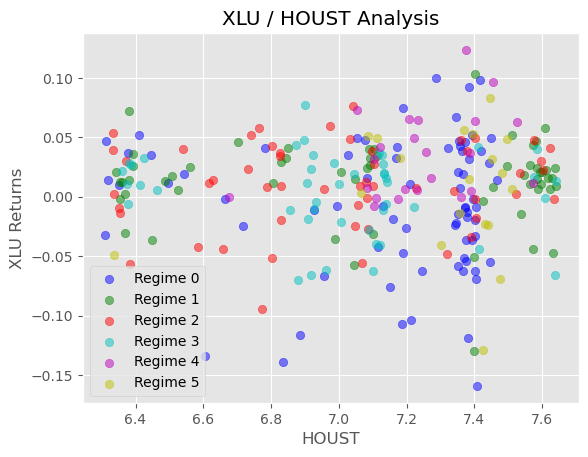

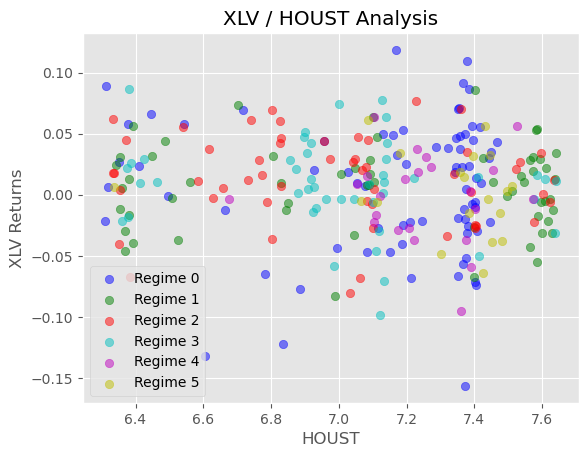

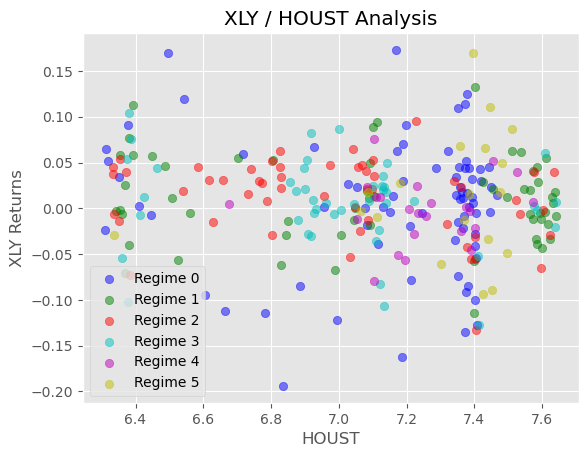

In [6]:
etfs = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
macro_var = 'HOUST'

for etf in etfs:
    plt.clf()
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    for i in range(6):
        plt.scatter(memory_data[-276:-1][macro_var][regimes[-275:]['cluster_step697'] == i], returns[etf][regimes[-275:]['cluster_step697'] == i], c=colors[i], label=f"Regime {i}", alpha=0.5)
    plt.title(f"{etf} / {macro_var} Analysis")
    plt.xlabel(macro_var)
    plt.ylabel(etf + " Returns")
    plt.legend()
    plt.show()

In [7]:
all_portfolio_returns = []
colors = ['r', 'b', 'g', 'y', 'm', 'c', 'k']
line_types = ['-', '--', '-.', ':']
styles = ['m', 'c']
for method in portfolio_methods:
    cur_color = colors.pop(0)
    dirs = os.listdir(os.path.join(outputs_path, method))

    for i, dir in enumerate(dirs):
        cur_line_type = line_types[i % len(line_types)]
        styles.append(f"{cur_color}{cur_line_type}")
        print(dir)

        results = load_pickle(os.path.join(outputs_path, method, dir))
        
        # get forecasts
        forecasts = results['forecasts']
        forecasts.index = pd.to_datetime(forecasts.index)
        forecasts.index.name = "date"

        # check which dataframe haas the smallest number of rows and match dates
        if len(forecasts) < len(returns):
            returns = returns.loc[forecasts.index[0]:forecasts.index[-1]]
        else:
            forecasts = forecasts.loc[returns.index[0]:returns.index[-1]]

        # match columns
        forecasts = forecasts[returns.columns]

        # portfolio returns
        portfolio_returns = forecasts.multiply(returns, axis=0)

        model_tag = dir.split('.')[0][8:]
        #long_only_tag = dir.split('.')[0].split('_')[1]
        #num_assets_tag = dir.split('.')[0].split('_')[2]
        portfolio_returns["models"] = f"{method}_{model_tag}"

        all_portfolio_returns.append(portfolio_returns.reset_index().melt(["models", "date"]))
all_portfolio_returns_df = pd.concat(all_portfolio_returns)

results_mx_4.pkl
results_mx_2.pkl
results_mx_3.pkl
results_lns_4.pkl
results_lo_2.pkl
results_lo_3_rand.pkl
results_lo_3.pkl
results_lns_3.pkl
results_lns_2.pkl
results_lo_4.pkl
results_los_3_rand.pkl
results_los_4.pkl
results_los_2.pkl
results_los_3.pkl
results_mx_4.pkl
results_mx_2.pkl
results_mx_3.pkl
results_lns_4.pkl
results_lo_2.pkl
results_lo_3.pkl
results_lns_3.pkl
results_lns_2.pkl
results_lo_4.pkl
results_los_4.pkl
results_los_2.pkl
results_los_3.pkl


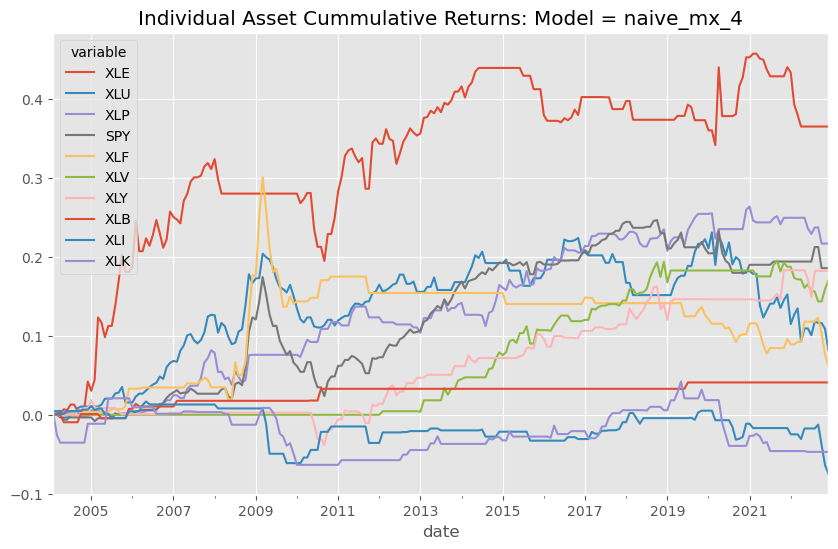

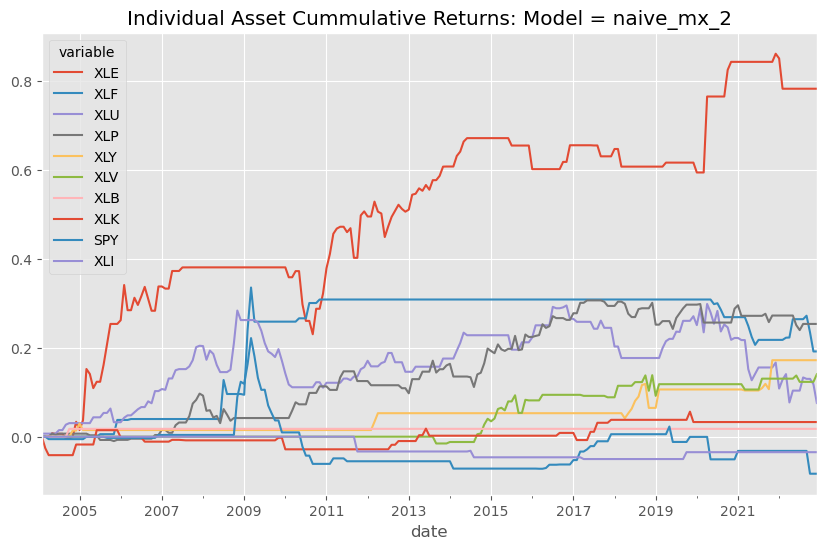

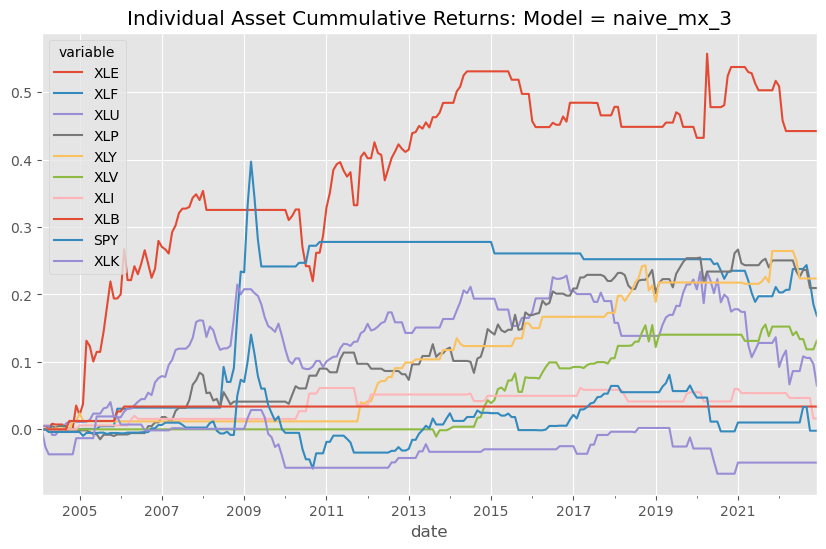

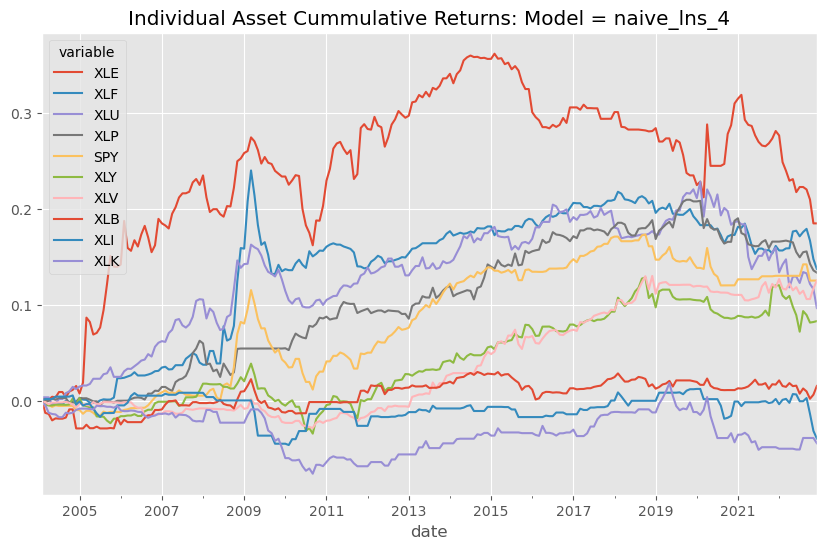

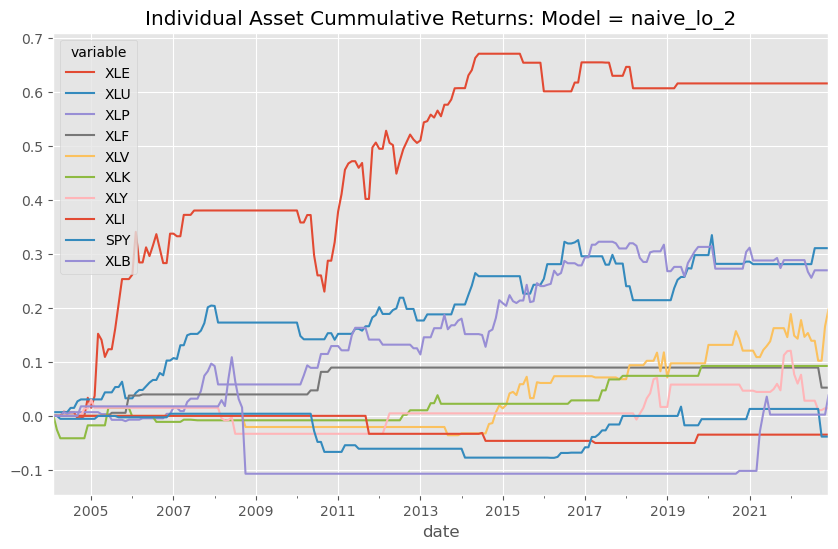

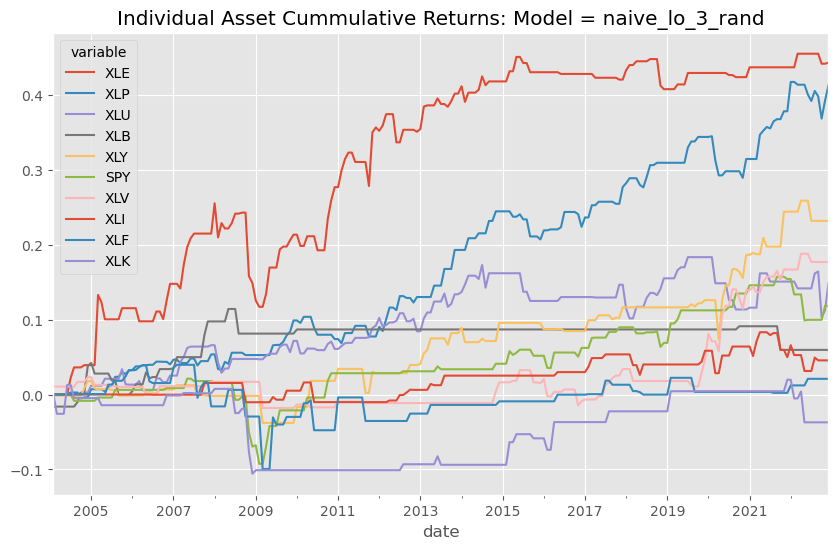

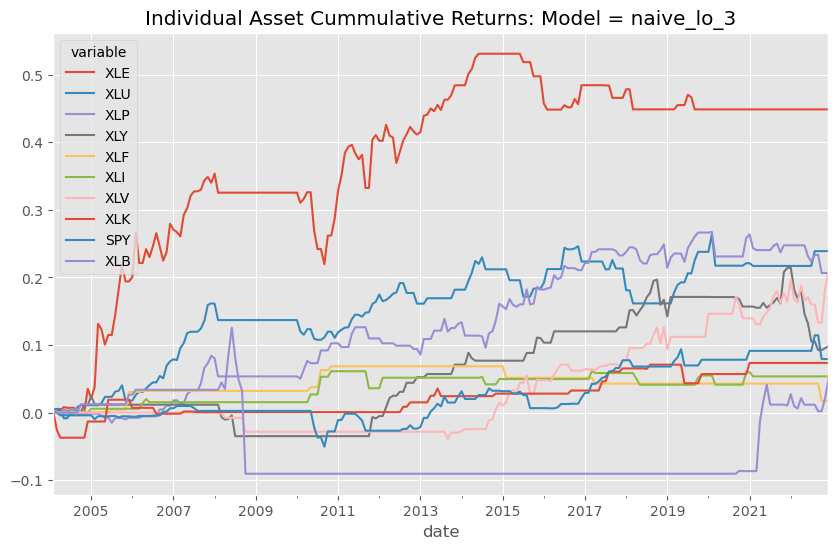

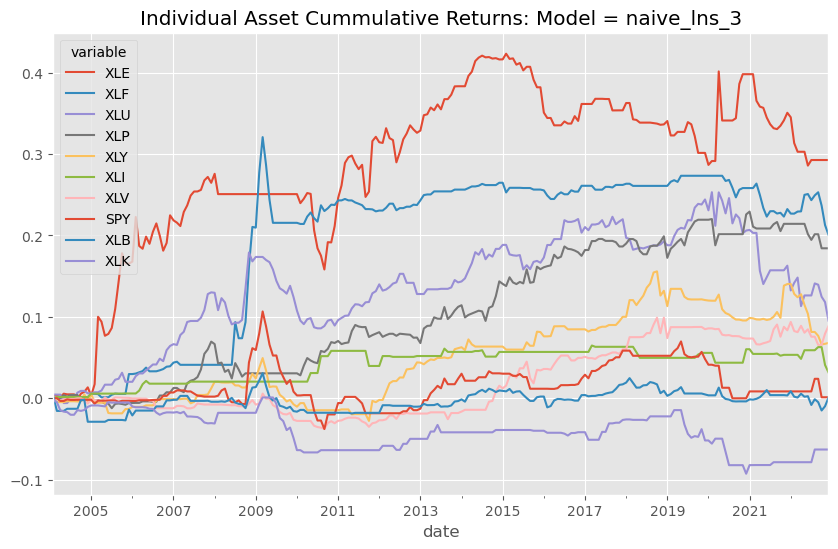

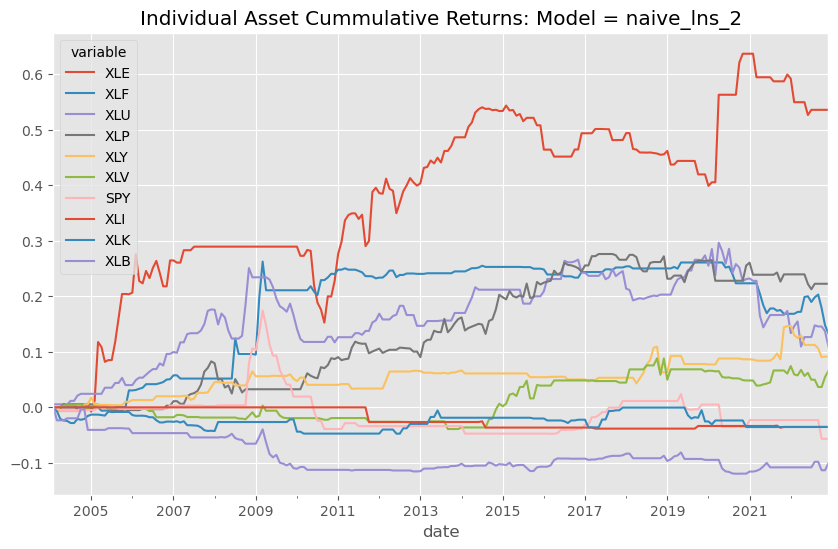

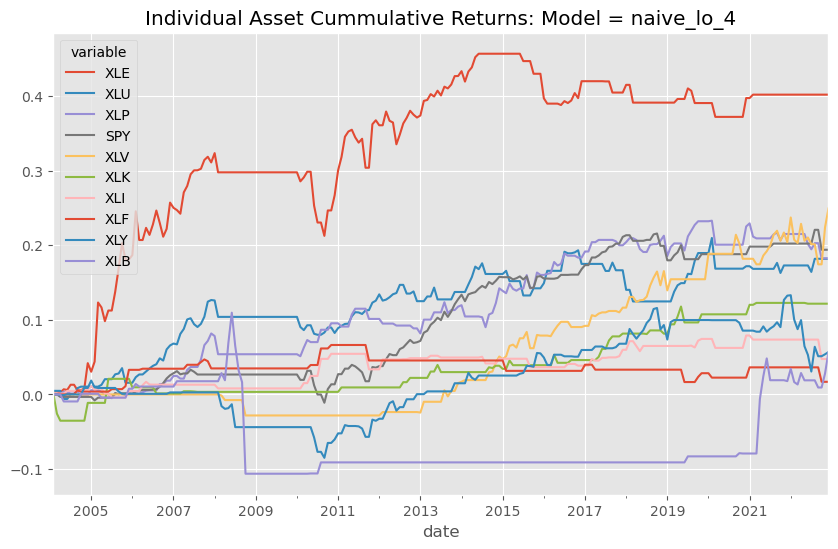

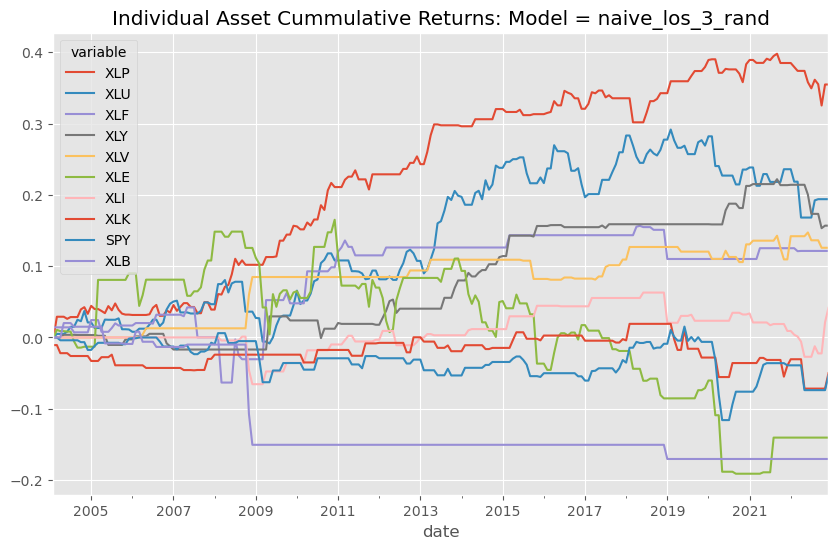

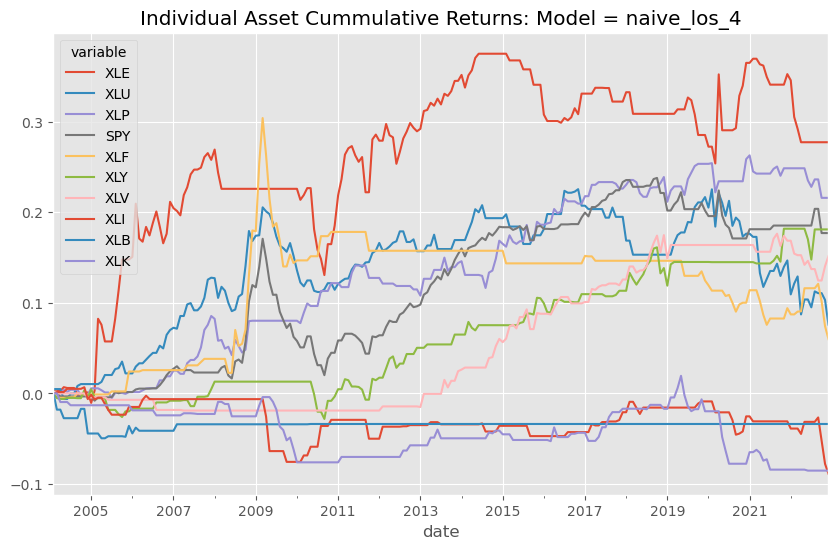

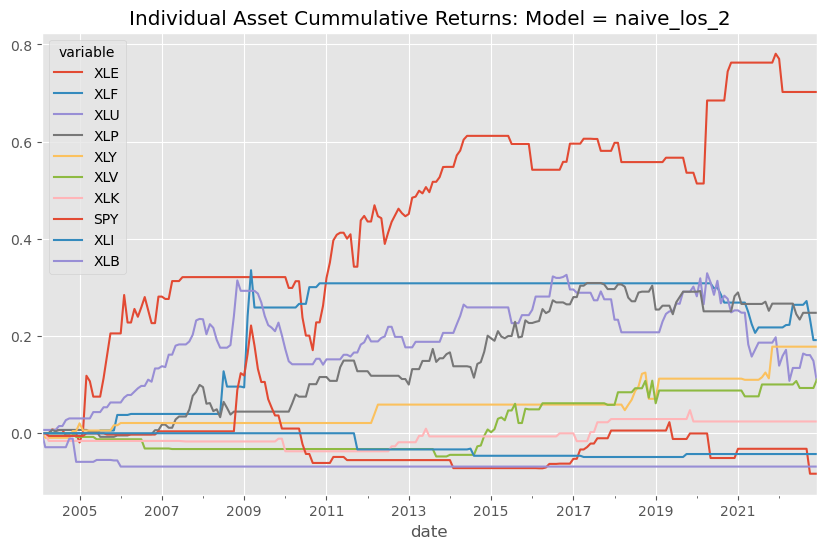

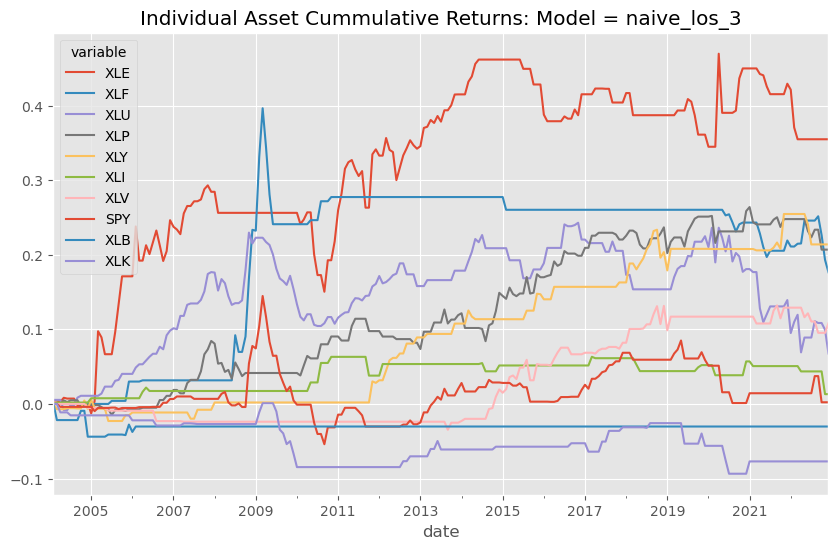

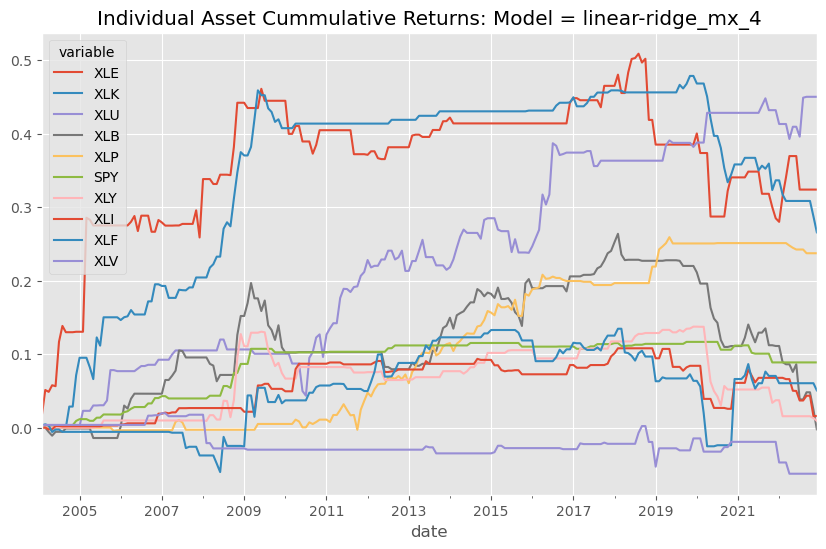

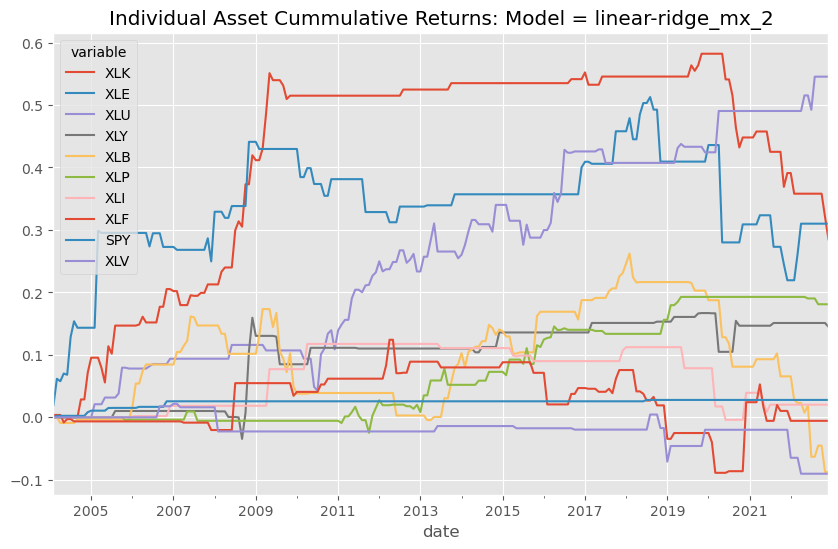

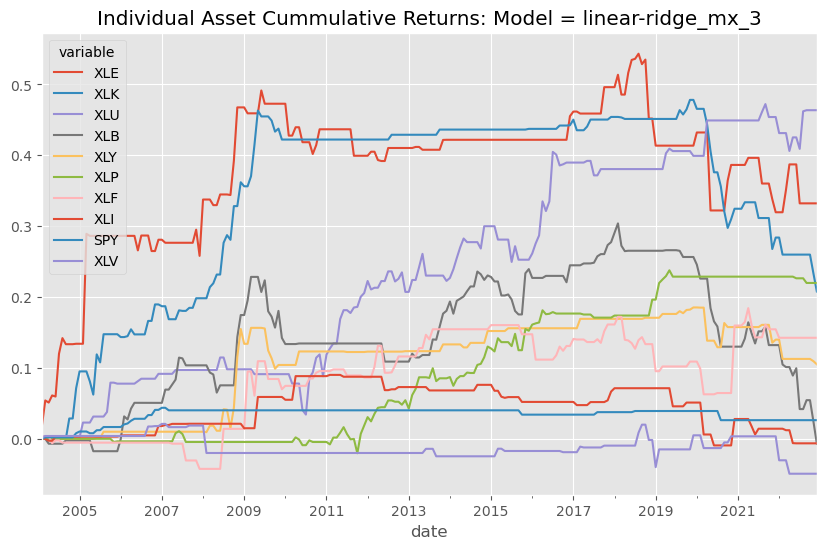

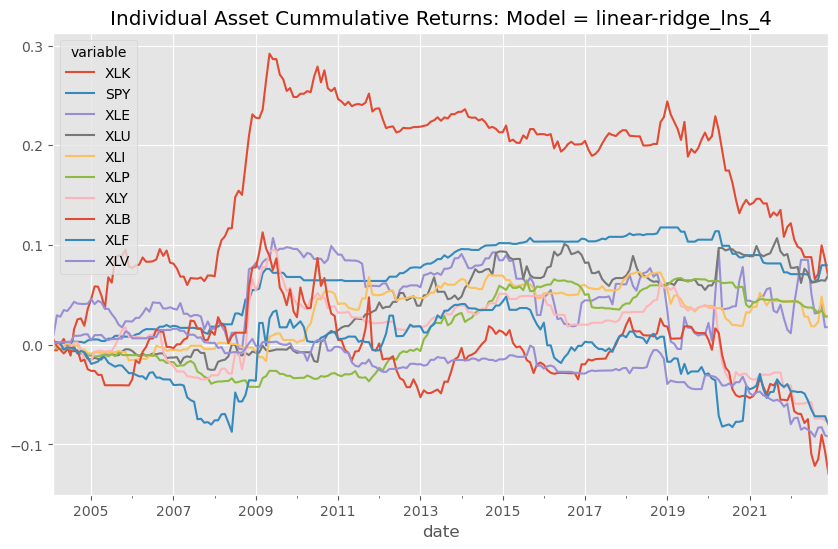

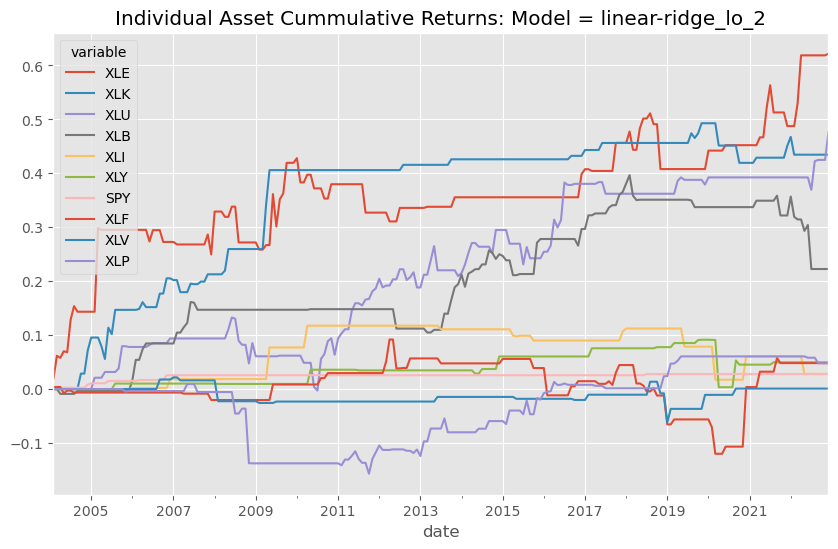

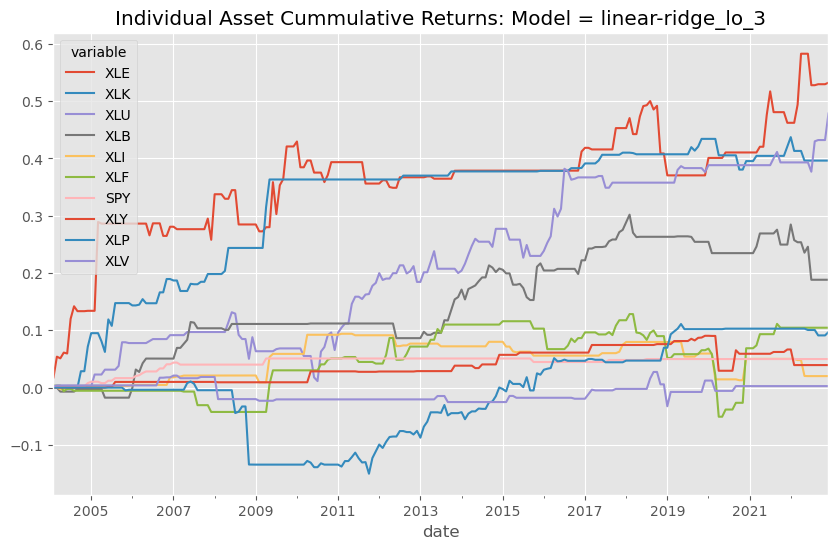

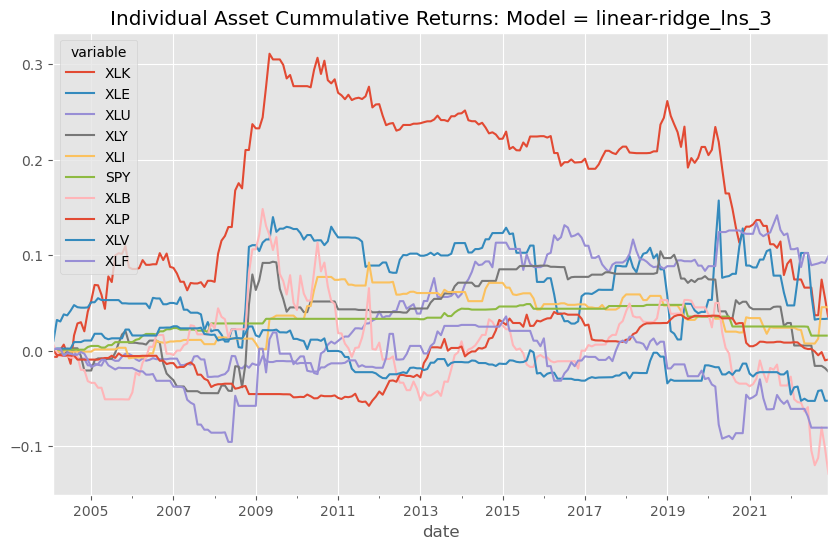

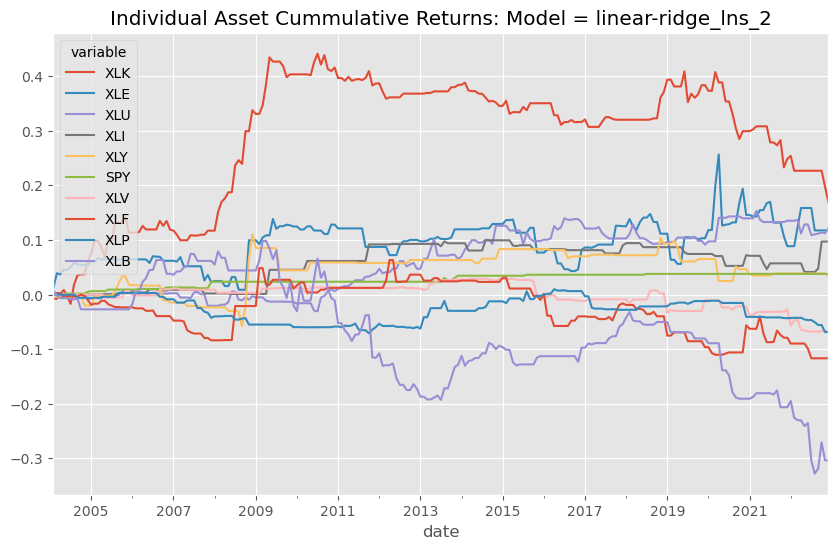

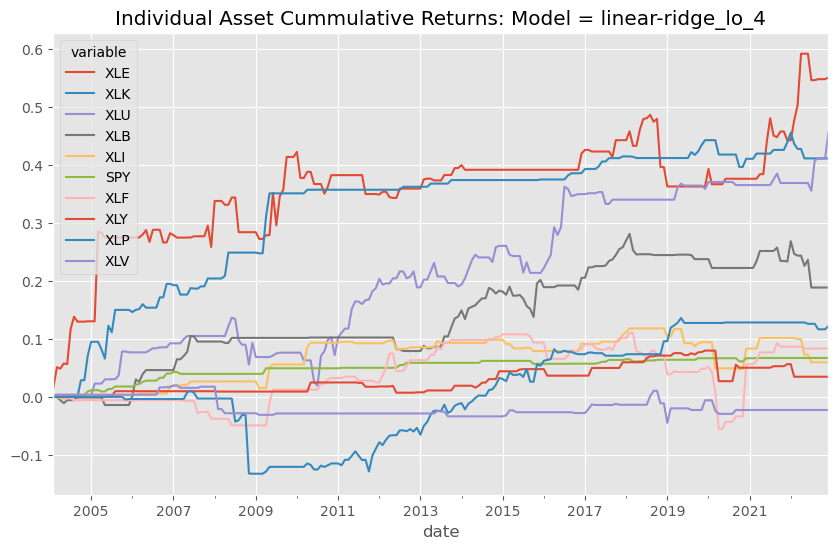

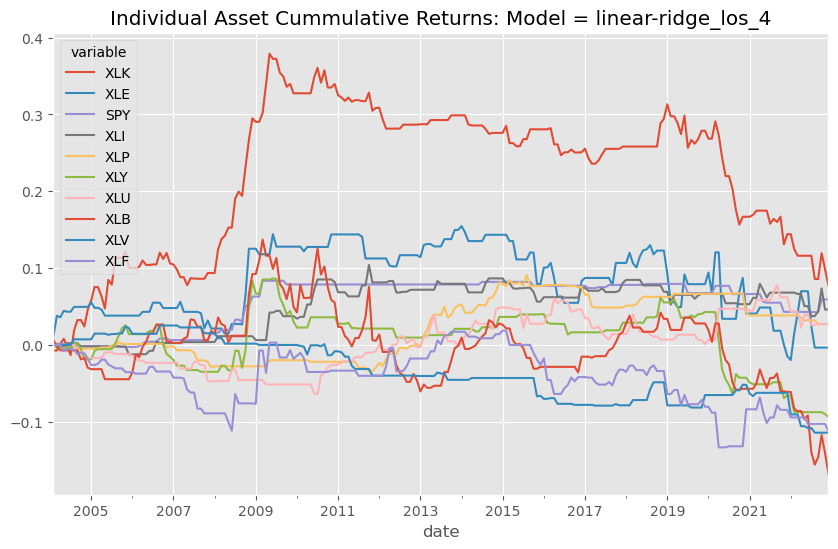

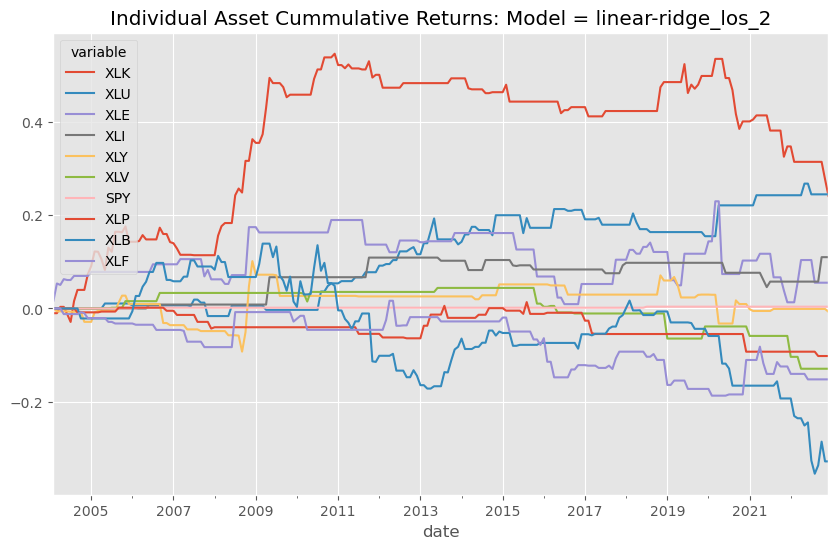

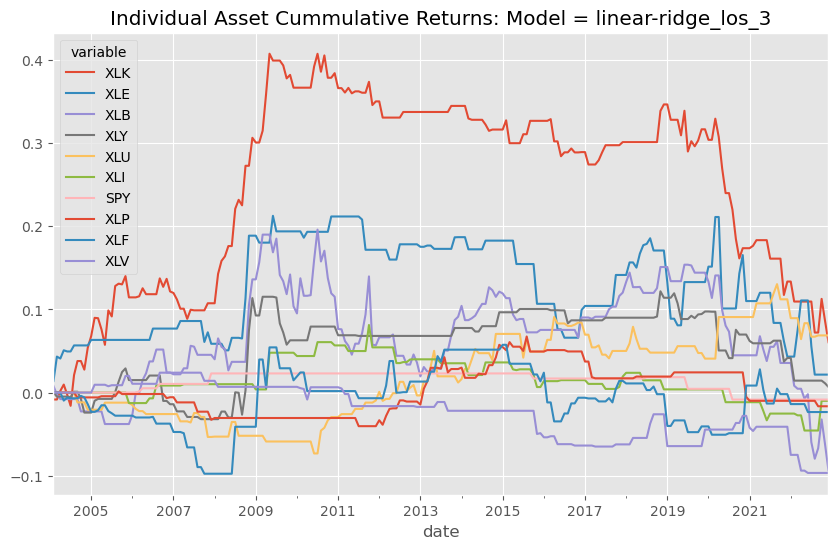

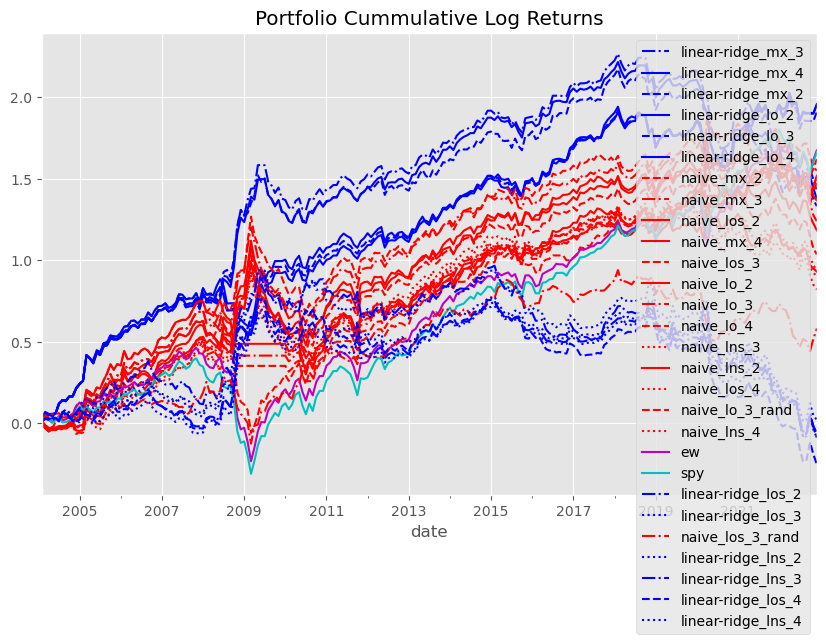

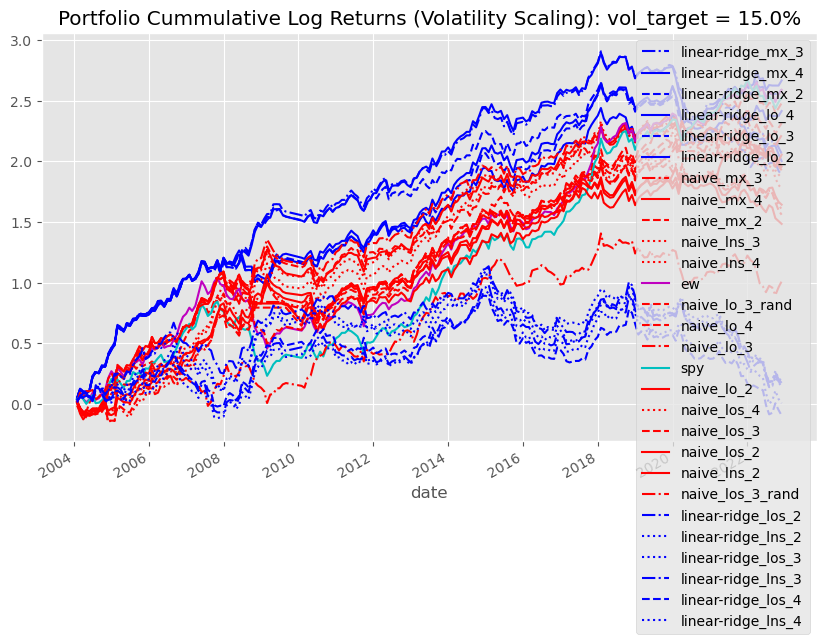

In [8]:
equal_weight_cumm_returns = pd.DataFrame(returns.mean(axis=1), columns=["ew"])
spy_cumm_returns = pd.DataFrame(pd.DataFrame(returns['SPY'], columns=["SPY"]).sum(axis=1), columns=["spy"])
concat_list = [equal_weight_cumm_returns, spy_cumm_returns]

for model in all_portfolio_returns_df["models"].unique():
    tmp_portfolio_returns = all_portfolio_returns_df[all_portfolio_returns_df["models"] == model]
    tmp_portfolio_returns = tmp_portfolio_returns.drop("models", axis=1).pivot_table(index="date", columns="variable", values="value")
    order = tmp_portfolio_returns.cumsum().mean(axis=0).sort_values(ascending=False).index
    tmp_portfolio_returns.cumsum()[order].plot(figsize=(10, 6), title=f"Individual Asset Cummulative Returns: Model = {model}")
    plt.show()

    # add equal weight
    concat_list.append(pd.DataFrame(tmp_portfolio_returns.sum(axis=1), columns=[model]))
cumm_returns_plot = pd.concat(concat_list, axis=1)
order = cumm_returns_plot.cumsum().mean(axis=0).sort_values(ascending=False).index
order_style = list(cumm_returns_plot.cumsum().mean(axis=0).argsort())
cumm_returns_plot.cumsum()[order].plot(figsize=(10, 6), style=[styles[x] for x in reversed(order_style)], title=f"Portfolio Cummulative Log Returns")
plt.show()

# volatility scaling
vol_target = 0.15
portfolio_vol = vol_target / (cumm_returns_plot.rolling(window=12).std().bfill() * np.sqrt(12))
cumm_returns_plot = (cumm_returns_plot * portfolio_vol).dropna()
order = cumm_returns_plot.cumsum().mean(axis=0).sort_values(ascending=False).index
order_style = list(cumm_returns_plot.cumsum().mean(axis=0).argsort())
cumm_returns_plot.cumsum()[order].plot(figsize=(10, 6), style=[styles[x] for x in reversed(order_style)], title=f"Portfolio Cummulative Log Returns (Volatility Scaling): vol_target = {vol_target * 100}%")
plt.show()

In [55]:
# ew_vol_scale = 10 / (equal_weight_cumm_returns.rolling(window=3).std() * 12 * 100)
# tensor_scaled_equal_weight_cumm_returns = torch.tensor((equal_weight_cumm_returns * ew_vol_scale).dropna().values)
ew_summary_statistics = compute_summary_statistics(torch.tensor(equal_weight_cumm_returns.values))
ew_summary_statistics = pd.DataFrame([ew_summary_statistics], index=["EW"])

all_summary_statistics = []
for model in all_portfolio_returns_df["models"].unique():
    tmp_portfolio_returns = all_portfolio_returns_df[all_portfolio_returns_df["models"] == model]
    tmp_portfolio_returns = tmp_portfolio_returns.drop("models", axis=1).pivot_table(index="date", columns="variable", values="value")

    vol_scale = 10 / (tmp_portfolio_returns.mean(axis=1).rolling(window=3).std() * 12 * 100)
    tensor_tmp_portfolio_returns = torch.tensor((tmp_portfolio_returns.mean(axis=1) * vol_scale).dropna().values)
    summary_statistics = compute_summary_statistics(tensor_tmp_portfolio_returns)
    summary_statistics = pd.DataFrame([summary_statistics], index=[model])

    all_summary_statistics.append(summary_statistics)
all_summary_statistics_df = pd.concat(all_summary_statistics)

all_summary_statistics_df

E[R]     Std(R)    Sharpe   Sortino      AvgDD  \
naive_mx_4          3.945650  20.645385  0.662043  1.944809  -2.286264   
naive_mx_2          4.139033  25.038304  0.572644  1.025091  -4.173809   
naive_mx_3          2.900854  13.704210  0.733268  1.216289  -2.625975   
naive_lns_4         2.502151  19.603486  0.442151  0.413192  -3.323573   
naive_lo_2          5.983601  23.627150  0.877287  3.952377  -0.973117   
naive_lo_3_rand     6.352867  25.091788  0.877059  3.843515  -0.865442   
naive_lo_3          4.402202  12.316328  1.238167  2.977042  -0.761249   
naive_lns_3         3.783684  14.497488  0.904092  1.852902  -2.094940   
naive_lns_2         4.740241  24.902382  0.659402  1.939702  -2.334957   
naive_lo_4          5.445104  20.435884  0.923003  3.554553  -0.747388   
naive_los_3_rand    0.902690  14.334143  0.218151  0.289334  -3.290237   
naive_los_4         3.439052  20.860382  0.571093  1.558876  -2.509046   
naive_los_2         3.739181  24.906763  0.520056  0.930919  -4.191257   
naive_los_3         2.419685  13.943328  0.601150  0.975761  -2.710280   
linear-ridge_mx_4   2.922023  12.073846  0.838356  1.545246  -1.804822   
linear-ridge_mx_2   2.859994  12.329606  0.803538  1.506398  -1.761696   
linear-ridge_mx_3   3.251425  13.462339  0.836650  1.744431  -1.527808   
linear-ridge_lns_4 -0.301076  17.693262 -0.058947 -0.058751 -10.770910   
linear-ridge_lo_2   4.103579  12.295885  1.156095  2.480882  -0.825626   
linear-ridge_lo_3   4.538153  13.416085  1.171774  2.504295  -0.852433   
linear-ridge_lns_3  0.926468  18.346730  0.174929  0.311123  -8.616107   
linear-ridge_lns_2  0.169495  19.034425  0.030847  0.048483 -10.434763   
linear-ridge_lo_4   4.782012  13.633499  1.215049  2.616443  -0.851374   
linear-ridge_los_4 -0.474583  15.103023 -0.108853 -0.128392 -11.376491   
linear-ridge_los_2  0.601895  13.302892  0.156735  0.290063  -4.788242   
linear-ridge_los_3  0.250267  15.594214  0.055594  0.072532  -7.757119   

                        MaxDD  % Positive Ret.  
naive_mx_4         -12.242555         0.564444  
naive_mx_2         -20.045172         0.582222  
naive_mx_3         -14.102918         0.573333  
naive_lns_4        -16.489205         0.560000  
naive_lo_2          -5.759782         0.602871  
naive_lo_3_rand     -7.700728         0.598214  
naive_lo_3          -4.798737         0.593301  
naive_lns_3         -9.892407         0.577778  
naive_lns_2        -11.576894         0.582222  
naive_lo_4          -4.798737         0.598086  
naive_los_3_rand   -11.595029         0.560000  
naive_los_4        -12.242555         0.555556  
naive_los_2        -20.045172         0.577778  
naive_los_3        -14.102918         0.564444  
linear-ridge_mx_4  -11.003203         0.564444  
linear-ridge_mx_2  -11.421429         0.546667  
linear-ridge_mx_3   -9.377933         0.573333  
linear-ridge_lns_4 -23.526763         0.506667  
linear-ridge_lo_2   -3.948980         0.551111  
linear-ridge_lo_3   -5.411700         0.586667  
linear-ridge_lns_3 -18.965711         0.493333  
linear-ridge_lns_2 -22.890254         0.466667  
linear-ridge_lo_4   -4.830383         0.582222  
linear-ridge_los_4 -20.845447         0.493333  
linear-ridge_los_2 -15.026168         0.497778  
linear-ridge_los_3 -20.185982         0.493333

In [56]:
groups_summary = all_summary_statistics_df.reset_index()
groups_summary["model"] = groups_summary["index"].apply(lambda x: x.split("_")[0])
groups_summary["type"] = groups_summary["index"].apply(lambda x: x.split("_")[1])
groups_summary["num_assets"] = groups_summary["index"].apply(lambda x: x.split("_")[2])
groups_summary["random tag"] = groups_summary["index"].apply(lambda x: x.split("_")[3] if len(x.split("_")) > 3 else None)

del groups_summary["index"]

In [57]:
tmp_df = groups_summary.loc[groups_summary["type"] == "lo"][["model", "num_assets", "random tag", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]].round(3)

pd.concat([tmp_df, ew_summary_statistics.round(3)])

model num_assets random tag  Sharpe  Sortino  AvgDD   MaxDD  \
4          naive          2       None   0.877    3.952 -0.973  -5.760   
5          naive          3       rand   0.877    3.844 -0.865  -7.701   
6          naive          3       None   1.238    2.977 -0.761  -4.799   
9          naive          4       None   0.923    3.555 -0.747  -4.799   
18  linear-ridge          2       None   1.156    2.481 -0.826  -3.949   
19  linear-ridge          3       None   1.172    2.504 -0.852  -5.412   
22  linear-ridge          4       None   1.215    2.616 -0.851  -4.830   
EW           NaN        NaN        NaN   0.592    0.699 -5.863 -50.183   

    % Positive Ret.   E[R]  Std(R)  
4             0.603    NaN     NaN  
5             0.598    NaN     NaN  
6             0.593    NaN     NaN  
9             0.598    NaN     NaN  
18            0.551    NaN     NaN  
19            0.587    NaN     NaN  
22            0.582    NaN     NaN  
EW            0.665  8.848  51.735

In [58]:
tmp_df = groups_summary.loc[groups_summary["type"] == "mx"][["model", "num_assets", "random tag", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]].round(3)

pd.concat([tmp_df, ew_summary_statistics.round(3)])

model num_assets random tag  Sharpe  Sortino  AvgDD   MaxDD  \
0          naive          4       None   0.662    1.945 -2.286 -12.243   
1          naive          2       None   0.573    1.025 -4.174 -20.045   
2          naive          3       None   0.733    1.216 -2.626 -14.103   
14  linear-ridge          4       None   0.838    1.545 -1.805 -11.003   
15  linear-ridge          2       None   0.804    1.506 -1.762 -11.421   
16  linear-ridge          3       None   0.837    1.744 -1.528  -9.378   
EW           NaN        NaN        NaN   0.592    0.699 -5.863 -50.183   

    % Positive Ret.   E[R]  Std(R)  
0             0.564    NaN     NaN  
1             0.582    NaN     NaN  
2             0.573    NaN     NaN  
14            0.564    NaN     NaN  
15            0.547    NaN     NaN  
16            0.573    NaN     NaN  
EW            0.665  8.848  51.735

In [59]:
groups_summary.loc[groups_summary["type"] == "los"][["model", "num_assets", "random tag", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]].round(3)

model num_assets random tag  Sharpe  Sortino   AvgDD   MaxDD  \
10         naive          3       rand   0.218    0.289  -3.290 -11.595   
11         naive          4       None   0.571    1.559  -2.509 -12.243   
12         naive          2       None   0.520    0.931  -4.191 -20.045   
13         naive          3       None   0.601    0.976  -2.710 -14.103   
23  linear-ridge          4       None  -0.109   -0.128 -11.376 -20.845   
24  linear-ridge          2       None   0.157    0.290  -4.788 -15.026   
25  linear-ridge          3       None   0.056    0.073  -7.757 -20.186   

    % Positive Ret.  
10            0.560  
11            0.556  
12            0.578  
13            0.564  
23            0.493  
24            0.498  
25            0.493